# Statistical analysis of quen llm models by size
**By:** *Carter Andrew*  
`11-23-2024`

# Intro
Here we have some introduction to the goal of this notebook

## Inspiration
TODO: There is some paper talking about how larger language models have a larger number of outliers with extreme values in their weights. I want to do my own investigation to confirm if this is true

# Setup
Here we import libraries, set up notebook behaviour, download models, ect...

In [1]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
from matplotlib import pyplot as plt

## Loading model
We can load our models for each size from `HuggingFace` by using their `transformers` library

In [2]:
# This can take a while...
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B")
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-0.5B")

# Intro
Here we have some introduction to the goal of this notebook

## Inspiration
TODO: There is some paper talking about how larger language models have a larger number of outliers with extreme values in their weights. I want to do my own investigation to confirm if this is true

# Setup
Here we import libraries, set up notebook behaviour, download models, ect...

In [3]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
from matplotlib import pyplot as plt

## Loading model
We can load our models for each size from `HuggingFace` by using their `transformers` library

In [4]:
# This can take a while...
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B")
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-0.5B")

# Exploration of Model
Here we explore the model and break down the different 

In [5]:
print(model)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((

This gives us a good understainding of the model architecture. As we can see the `model` object consists of:
1. An embedding layer. This matrix allows us to look up an embedding of size `826` from one of any of our tokens in our vocabulary (ordered 0 to 151936)
2. There are 24 transformer layers each containing:
   1. A self attention mechanism made of:
      1. A query, key and value projection of our embedding
      2. A output projection to transform our generated embedding into a token of `826` dimensions
      3. A rotary embedding for positional encoding
   2. A feed-forward (or muli-layer perceptron) layer that upscales our model to size `4864` for an intermediate step and uses SiLU for activation
   3. Layer normalization handled by the input_layernorm and post_attention_layernorm
3. Next our transformer output get normalized and has additional rotatry embedding is done
4. Finally we put our outputs through a head mechanism that transforms our input back into a output of our vocabulary size of `151936`

## Weight analysis by layer

### Means

In [6]:
# Dictionary to store statistics
stats = []

# Iterate through model parameters
for name, param in model.named_parameters():
    if param.requires_grad:  # Consider only trainable parameters
        stats.append([
            name,
            param.data.mean().item(),
            param.data.std().item(),
            param.data.min().item(),
            param.data.max().item(),
            param.data.shape
        ])
stats = pd.DataFrame(stats, columns=['name', 'mean', 'std', 'min', 'max', 'shape'])
stats.head()

,name,mean,std,min,max,shape
0,model.embed_tokens.weight,0.000054,0.015613,-0.205078,0.166016,"(151936, 896)"
1,model.layers.0.self_attn.q_proj.weight,-0.000019,0.067723,-1.250000,1.195312,"(896, 896)"
2,model.layers.0.self_attn.q_proj.bias,-0.152019,7.854486,-79.000000,47.750000,"(896,)"
3,model.layers.0.self_attn.k_proj.weight,0.000143,0.081710,-1.031250,0.925781,"(128, 896)"
4,model.layers.0.self_attn.k_proj.bias,3.860678,32.335621,-130.000000,121.000000,"(128,)"


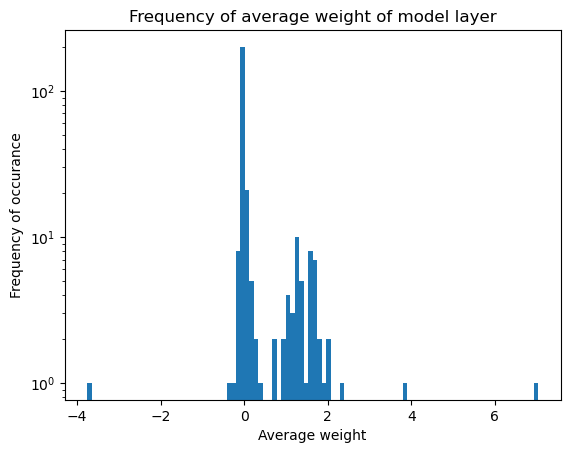

In [7]:
plt.hist(
    stats['mean'],
    bins=100
)
plt.title('Frequency of average weight of model layer')
plt.ylabel("Frequency of occurance")
plt.xlabel("Average weight")
plt.yscale('log')
plt.show();

It looks like most of our means fall within the 0-2 range with a large amount focused closely around zero

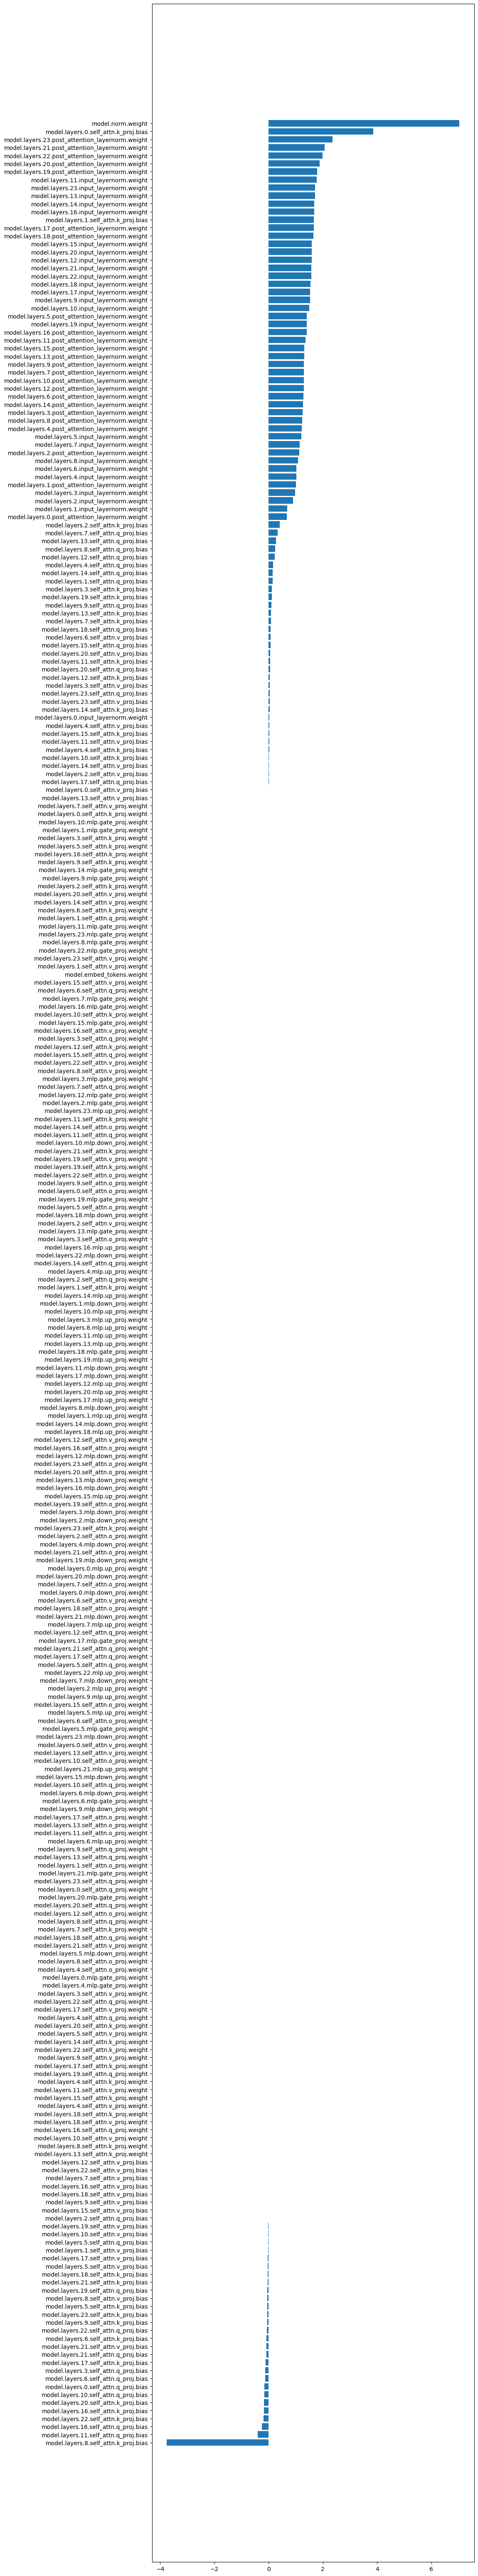

In [8]:
stats = stats.sort_values(by='mean')
plt.figure(figsize=(10,80))
plt.barh(stats['name'], stats['mean'])
plt.show();

In [9]:
weights = [param.data.flatten().numpy() for name, param in model.named_parameters()]

sample_weights = [np.random.choice(
    layer,
    size=min(len(layer), 2000),
    replace=False
) for layer in weights]
del weights

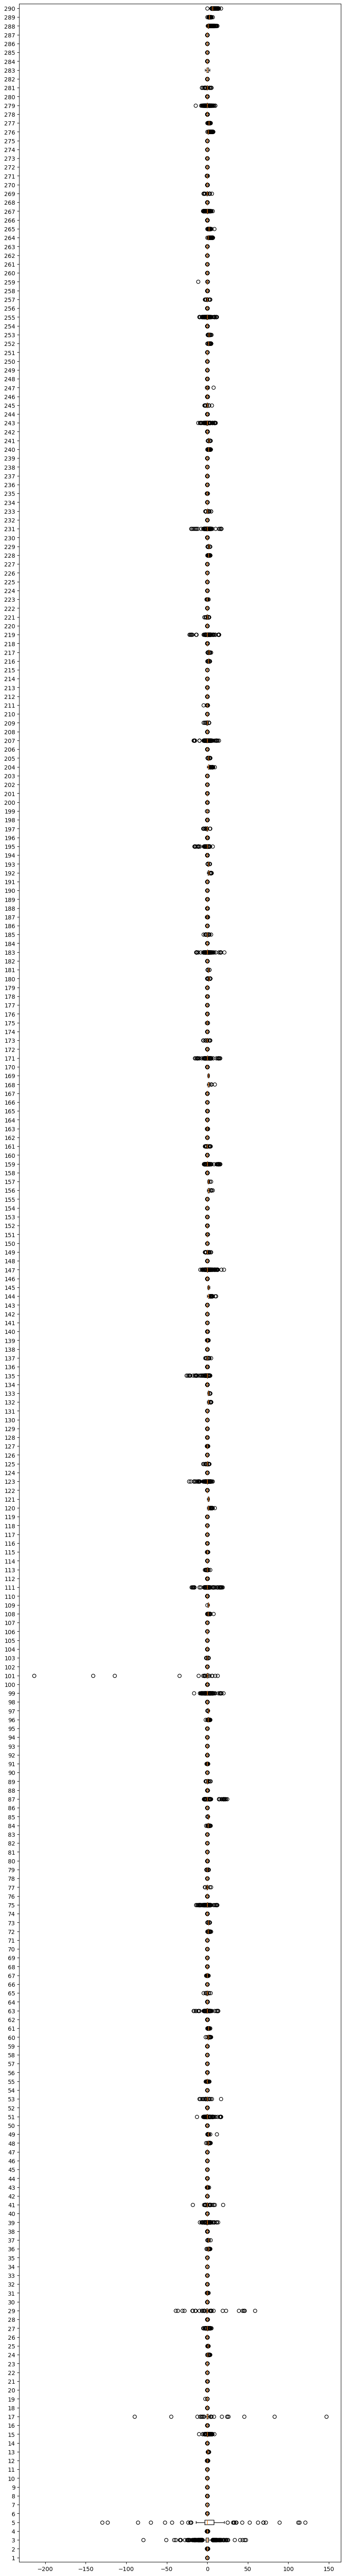

In [10]:
plt.figure(figsize=(10,80))
plt.boxplot(sample_weights, vert=False)
plt.show();

In [11]:
from scipy.stats import zscore

outlier_props = [np.mean(np.abs(zscore(layer)) > 3) for layer in sample_weights]

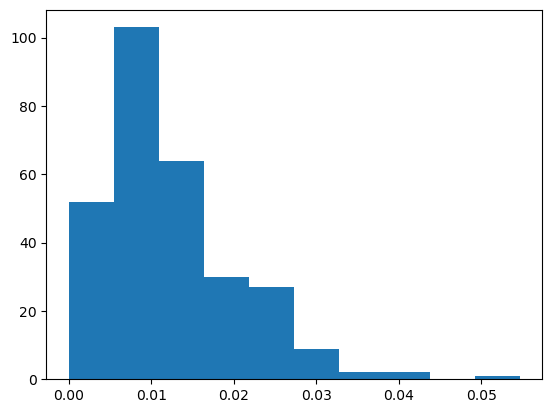

In [12]:
plt.hist(outlier_props);

It looks like we have a very small proportion of outliers. Next I want to group this by layer type

In [13]:
weights = {name: param.data.flatten().numpy() for name, param in model.named_parameters()}

In [14]:
len(weights.keys())

290

# Grouping By Layer Type

In [15]:
names = [name for name, param in model.named_parameters()]

In [16]:
names

['model.embed_tokens.weight',
 'model.layers.0.self_attn.q_proj.weight',
 'model.layers.0.self_attn.q_proj.bias',
 'model.layers.0.self_attn.k_proj.weight',
 'model.layers.0.self_attn.k_proj.bias',
 'model.layers.0.self_attn.v_proj.weight',
 'model.layers.0.self_attn.v_proj.bias',
 'model.layers.0.self_attn.o_proj.weight',
 'model.layers.0.mlp.gate_proj.weight',
 'model.layers.0.mlp.up_proj.weight',
 'model.layers.0.mlp.down_proj.weight',
 'model.layers.0.input_layernorm.weight',
 'model.layers.0.post_attention_layernorm.weight',
 'model.layers.1.self_attn.q_proj.weight',
 'model.layers.1.self_attn.q_proj.bias',
 'model.layers.1.self_attn.k_proj.weight',
 'model.layers.1.self_attn.k_proj.bias',
 'model.layers.1.self_attn.v_proj.weight',
 'model.layers.1.self_attn.v_proj.bias',
 'model.layers.1.self_attn.o_proj.weight',
 'model.layers.1.mlp.gate_proj.weight',
 'model.layers.1.mlp.up_proj.weight',
 'model.layers.1.mlp.down_proj.weight',
 'model.layers.1.input_layernorm.weight',
 'model.l

In [17]:
self_attn_layer_indicies = [index for index, name in enumerate(names) if 'self_attn' in name]
len(self_attn_layer_indicies)

168

In [18]:
norm_layer_indicies = [index for index, name in enumerate(names) if 'norm' in name]
len(norm_layer_indicies)

49

In [19]:
mlp_layer_indicies = [index for index, name in enumerate(names) if 'mlp' in name]
len(mlp_layer_indicies)

72

In [20]:
len(names) - len(self_attn_layer_indicies) - len(norm_layer_indicies) - len(mlp_layer_indicies)

1

The signular layer we have left is the embedding layer at the start, that can recive it's own group

In [21]:
embedding_layer_indicies = [0]

In [22]:
params = [param.data.flatten().numpy() for name, param in model.named_parameters()]
grouped_params = {
    'Embedding': [params[i] for i in embedding_layer_indicies],
    'Self Attention': [params[i] for i in self_attn_layer_indicies],
    'Normalization Layers': [params[i] for i in norm_layer_indicies],
    'Mutli Layer Perceptron Layers': [params[i] for i in mlp_layer_indicies],
}
grouped_outlier_props = [np.mean(np.abs(zscore(layer)) > 3) for layer in sample_weights]
grouped_outlier_props = {
    name: [np.mean(np.abs(zscore(layer)) > 3) for layer in layers] for name, layers in grouped_params.items() 
}

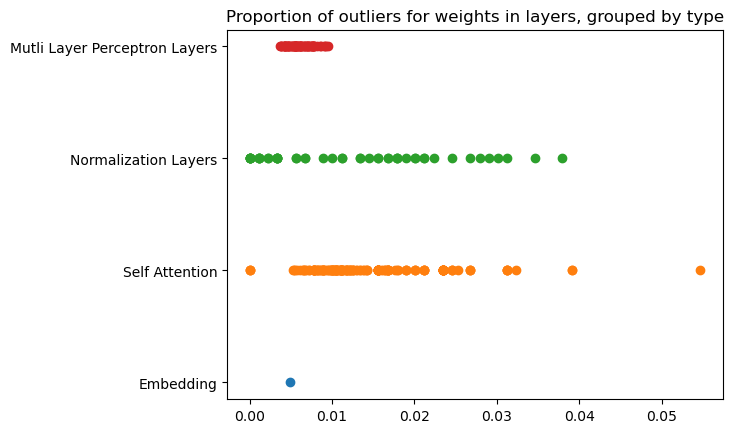

In [23]:
fig, ax = plt.subplots()
for i, (key, values) in enumerate(grouped_outlier_props.items()):
    ax.scatter(values, [key] * len(values), label=key)
plt.title("Proportion of outliers for weights in layers, grouped by type")
plt.show();

In [26]:
self_attn_layers = [params for name, params in model.named_parameters()]

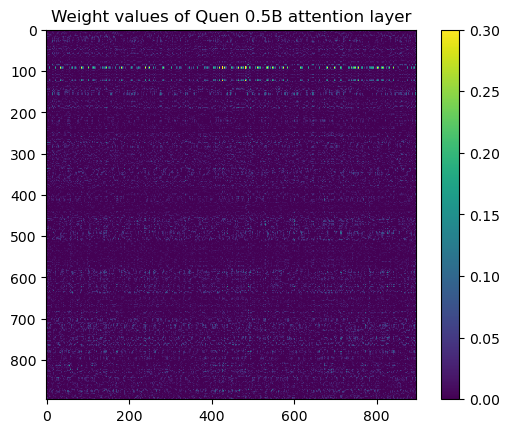

In [69]:
layer = self_attn_layers[1].detach().numpy()
plt.imshow(layer, vmax=.3, vmin=0)
plt.colorbar()
plt.title("Weight values of Quen 0.5B attention layer")
plt.show();
i += 1